In [ ]:
# Colab cell 1: mount Drive and install deps
from google.colab import drive
drive.mount('/content/drive')   # follow the authentication link

# Install required packages
!pip install -q scikit-learn lightgbm shap joblib fastapi uvicorn pyngrok jinja2 weasyprint matplotlib plotly
# (If weasyprint fails on Colab due to system deps, we'll fallback to simple HTML or save plots as PNG)


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.1/851.1 kB 37.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
df = pd.read_csv('/content/dataset.csv')
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
# ---------------------------
# Cell 3 (fixed): Preprocessing & save transformer
# ---------------------------

import os
import pandas as pd
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- 1) Load dataset (you said /content/dataset.csv) ---
csv_path = "/content/dataset.csv"
assert os.path.exists(csv_path), f"File not found: {csv_path}"
df = pd.read_csv(csv_path)
print("Loaded dataset. Shape:", df.shape)
print("Columns:", df.columns.tolist())

# --- 1.5) Quick cleanup: drop ID column if present ---
if 'Loan_ID' in df.columns:
    print("Dropping Loan_ID column (identifier).")
    df = df.drop(columns=['Loan_ID'])

# --- 2) Identify / normalize target column ---
possible_targets = ['approved','Approved','Loan_Status','loan_status','target','label','Loan_Status']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break

if target_col is None:
    # If no obvious target, create a temporary dummy target (useful for testing preprocessing)
    print("No target column found. Creating a temporary 'approved' column with 1s.")
    df['approved'] = 1
    target_col = 'approved'
else:
    # Normalize common values (for example many datasets use 'Y'/'N' in Loan_Status)
    if target_col == 'Loan_Status' or df[target_col].dtype == object:
        # map common string values to 1/0
        df[target_col] = df[target_col].map({'Y':1,'N':0,'Yes':1,'No':0}).fillna(df[target_col])
    # rename to 'approved' for consistency
    if target_col != 'approved':
        df.rename(columns={target_col: 'approved'}, inplace=True)
        target_col = 'approved'
    print("Using target column:", target_col)

# --- 3) Split features / target ---
X = df.drop(columns=[target_col])
y = df[target_col]

# --- 4) Identify numeric & categorical features automatically ---
numeric_features = X.select_dtypes(include=['int64','float64','float32','int32']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# --- 5) Build transformers ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Use sparse_output=False (modern sklearn) to get dense arrays for concatenation
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')   # drop any other columns

# --- 6) Fit preprocessor ---
print("Fitting preprocessor...")
preprocessor.fit(X, y)
print("Preprocessor fitted.")

# --- 7) Save artifact (drive if mounted, otherwise /content/artifacts) ---
save_dir = "/content/artifacts"
# prefer Google Drive if mounted at /content/drive/MyDrive
if os.path.exists("/content/drive/MyDrive"):
    save_dir = "/content/drive/MyDrive/loan_project/artifacts"
os.makedirs(save_dir, exist_ok=True)
transformer_path = os.path.join(save_dir, "transformer.joblib")
joblib.dump(preprocessor, transformer_path)
print(f"Saved transformer to: {transformer_path}")

# --- 8) quick test: transform first row and show shape ---
sample_t = preprocessor.transform(X.iloc[[0]])
print("Sample transformed shape:", sample_t.shape)


Loaded dataset. Shape: (614, 13)
Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']
Dropping Loan_ID column (identifier).
Using target column: approved
Numeric features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
Fitting preprocessor...
Preprocessor fitted.
Saved transformer to: /content/drive/MyDrive/loan_project/artifacts/transformer.joblib
Sample transformed shape: (1, 20)


In [ ]:
# ---------------------------
# Cell 4: Train models (Logistic + LightGBM) + Calibrate probabilities
# ---------------------------

import os
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.isotonic import IsotonicRegression
import lightgbm as lgb

# ---------- Paths ----------
csv_path = "/content/dataset.csv"
assert os.path.exists(csv_path), f"Dataset not found: {csv_path}"

# prefer Drive save location if mounted
save_dir = "/content/artifacts"
if os.path.exists("/content/drive/MyDrive"):
    save_dir = "/content/drive/MyDrive/loan_project/artifacts"
os.makedirs(save_dir, exist_ok=True)

# ---------- Load data & transformer ----------
df = pd.read_csv(csv_path)
print("Loaded dataset:", df.shape)

# If target column is Loan_Status, map and rename (same logic used earlier)
if 'Loan_Status' in df.columns and 'approved' not in df.columns:
    df['Loan_Status'] = df['Loan_Status'].map({'Y':1,'N':0,'Yes':1,'No':0}).fillna(df['Loan_Status'])
    df.rename(columns={'Loan_Status':'approved'}, inplace=True)

if 'approved' not in df.columns:
    raise ValueError("Target column 'approved' not found in dataset. Add it or run preprocessing correctly.")

# drop ID column if present
if 'Loan_ID' in df.columns:
    df = df.drop(columns=['Loan_ID'])

# Load preprocessor
transformer_path = os.path.join(save_dir, "transformer.joblib")
assert os.path.exists(transformer_path), f"Transformer not found at {transformer_path}. Run preprocessing cell first."
preprocessor = joblib.load(transformer_path)
print("Loaded transformer from:", transformer_path)

# ---------- Split data ----------
X = df.drop(columns=['approved'])
y = df['approved'].astype(int)

# We'll create 3-way split: train / calibration / test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42)
# results: train ~60%, calib ~20%, test ~20%

print("Split sizes -> train:", X_train.shape, "calib:", X_calib.shape, "test:", X_test.shape)

# Transform datasets
X_train_t = preprocessor.transform(X_train)
X_calib_t = preprocessor.transform(X_calib)
X_test_t = preprocessor.transform(X_test)

# ---------- Train Logistic Regression baseline ----------
print("\nTraining Logistic Regression...")
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
lr.fit(X_train_t, y_train)
y_test_proba_lr = lr.predict_proba(X_test_t)[:,1]
auc_lr = roc_auc_score(y_test, y_test_proba_lr)
print(f"Logistic Regression AUC on test: {auc_lr:.4f}")

# Save logistic
lr_path = os.path.join(save_dir, "logistic.pkl")
joblib.dump(lr, lr_path)
print("Saved Logistic model to:", lr_path)

# ---------- Train LightGBM (using callbacks for early stopping/logging) ----------
print("\nTraining LightGBM...")
train_data = lgb.Dataset(X_train_t, label=y_train)
valid_data = lgb.Dataset(X_calib_t, label=y_calib, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'seed': 42,
    'verbosity': -1
}

# Use callbacks for early stopping and periodic logging (works across versions)
try:
    from lightgbm import early_stopping, log_evaluation
    callbacks = [early_stopping(stopping_rounds=50), log_evaluation(period=100)]
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[valid_data],
        callbacks=callbacks
    )
except Exception as e:
    # fallback: try without callbacks (older/newer versions)
    print("Callback approach failed, falling back to simple train(). Error:", e)
    model = lgb.train(params, train_data, num_boost_round=200)

# Evaluate on test
y_test_proba_lgb = model.predict(X_test_t, num_iteration=getattr(model, "best_iteration", None) or None)
auc_lgb = roc_auc_score(y_test, y_test_proba_lgb)
print(f"LightGBM AUC on test: {auc_lgb:.4f}")

# Save LightGBM
lgb_path = os.path.join(save_dir, "lightgbm.txt")
model.save_model(lgb_path)
print("Saved LightGBM model to:", lgb_path)

# ---------- Calibrate probabilities with Isotonic Regression ----------
print("\nCalibrating probabilities with IsotonicRegression (using calibration fold)...")
y_calib_pred = model.predict(X_calib_t, num_iteration=getattr(model, "best_iteration", None) or None)
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(y_calib_pred, y_calib)   # map raw pred -> true labels on calibration fold

# Test calibration on test set
y_test_calibrated = iso.predict(y_test_proba_lgb)
cal_auc = roc_auc_score(y_test, y_test_calibrated)
print(f"Calibrated LightGBM AUC on test: {cal_auc:.4f} (should be similar to raw AUC)")

# Save calibrator
iso_path = os.path.join(save_dir, "isotonic.joblib")
joblib.dump(iso, iso_path)
print("Saved Isotonic calibrator to:", iso_path)

# ---------- Quick classification reports (optional thresholds) ----------
print("\nQuick classification (threshold 0.5 on calibrated probs):")
y_pred_label = (y_test_calibrated >= 0.5).astype(int)
print(classification_report(y_test, y_pred_label))

# ---------- Save metadata ----------
meta = {
    'lgb_path': lgb_path,
    'lr_path': lr_path,
    'iso_path': iso_path,
    'transformer_path': transformer_path,
    'lgb_auc': float(auc_lgb),
    'lr_auc': float(auc_lr)
}
joblib.dump(meta, os.path.join(save_dir, "model_metadata.joblib"))
print("\nSaved metadata to:", os.path.join(save_dir, "model_metadata.joblib"))

# ---------- Example inference on a sample ----------
print("\nExample inference on first test row:")
sample_X = X_test.iloc[[0]]
sample_t = preprocessor.transform(sample_X)
p_raw = model.predict(sample_t, num_iteration=getattr(model, "best_iteration", None) or None)[0]
p_cal = float(iso.predict([p_raw])[0])
p_lr_sample = float(lr.predict_proba(sample_t)[:,1][0])
print("p_raw (LGB):", p_raw)
print("p_calibrated:", p_cal)
print("p_logistic:", p_lr_sample)

print("\n✅ Training complete. Models & artifacts saved to:", save_dir)


Loaded dataset: (614, 13)
Loaded transformer from: /content/drive/MyDrive/loan_project/artifacts/transformer.joblib
Split sizes -> train: (368, 11) calib: (123, 11) test: (123, 11)

Training Logistic Regression...
Logistic Regression AUC on test: 0.8560
Saved Logistic model to: /content/drive/MyDrive/loan_project/artifacts/logistic.pkl

Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.821886
LightGBM AUC on test: 0.8002
Saved LightGBM model to: /content/drive/MyDrive/loan_project/artifacts/lightgbm.txt

Calibrating probabilities with IsotonicRegression (using calibration fold)...
Calibrated LightGBM AUC on test: 0.8067 (should be similar to raw AUC)
Saved Isotonic calibrator to: /content/drive/MyDrive/loan_project/artifacts/isotonic.joblib

Quick classification (threshold 0.5 on calibrated probs):
              precision    recall  f1-score   support

           0       0.95      0.55      0.70    

In [ ]:
# ---------------------------
# Cell 5: SHAP explainer + inference helper
# ---------------------------

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import lightgbm as lgb

# ---------- Paths (adjust if needed) ----------
save_dir = "/content/artifacts"
if os.path.exists("/content/drive/MyDrive"):
    save_dir = "/content/drive/MyDrive/loan_project/artifacts"

transformer_path = os.path.join(save_dir, "transformer.joblib")
lgb_path = os.path.join(save_dir, "lightgbm.txt")
lr_path = os.path.join(save_dir, "logistic.pkl")
iso_path = os.path.join(save_dir, "isotonic.joblib")
meta_path = os.path.join(save_dir, "model_metadata.joblib")

# ---------- Load artifacts ----------
assert os.path.exists(transformer_path), "Transformer not found. Run preprocessing cell first."
assert os.path.exists(lgb_path), "LightGBM model not found. Run training cell first."
assert os.path.exists(lr_path), "Logistic model not found. Run training cell first."
assert os.path.exists(iso_path), "Isotonic calibrator not found. Run training cell first."

preprocessor = joblib.load(transformer_path)
model = lgb.Booster(model_file=lgb_path)
lr = joblib.load(lr_path)
iso = joblib.load(iso_path)

print("Loaded artifacts from:", save_dir)

# ---------- Utility: get transformed feature names from ColumnTransformer ----------
def get_transformed_feature_names(column_transformer, numeric_features=None, categorical_features=None):
    """
    Attempts to reconstruct the feature names after ColumnTransformer.
    Works for pipelines with StandardScaler (numeric) and OneHotEncoder (categorical).
    """
    feature_names = []
    # If user provided feature lists use them, else try to infer from fitted transformer
    if numeric_features is None or categorical_features is None:
        # Try to infer original X columns by inspecting transformers
        # This is heuristic — best if you keep numeric/categorical lists from preprocessing step
        transformers = getattr(column_transformer, "transformers_", None)
        if transformers is None:
            return []
    # We'll try a robust approach: iterate transformers_ and extract names
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if isinstance(trans, Pipeline):
            # get last step
            last_step = trans.steps[-1][1]
        else:
            last_step = trans
        if hasattr(last_step, 'get_feature_names_out'):
            try:
                # For OneHotEncoder or similar
                names = last_step.get_feature_names_out(cols)
                feature_names.extend(list(names))
            except Exception:
                # fallback: use cols as-is
                if isinstance(cols, (list, tuple, np.ndarray)):
                    feature_names.extend(list(cols))
                else:
                    feature_names.append(str(cols))
        else:
            # no get_feature_names_out -> fallback to cols
            if isinstance(cols, (list, tuple, np.ndarray)):
                feature_names.extend(list(cols))
            else:
                feature_names.append(str(cols))
    return feature_names

# Try to extract numeric/categorical from preprocessor if it's a ColumnTransformer or Pipeline
orig_numeric = None
orig_categorical = None
try:
    # If transformer is a Pipeline with FeatureEngineer -> ColumnTransformer
    if hasattr(preprocessor, 'named_steps'):
        # find ColumnTransformer inside
        for step_name, step in preprocessor.named_steps.items():
            if isinstance(step, (type(preprocessor))):
                pass
    # If it's a ColumnTransformer directly
    if hasattr(preprocessor, "transformers_"):
        feature_names = get_transformed_feature_names(preprocessor)
    else:
        # maybe it's a Pipeline with ColumnTransformer inside
        ct = None
        for name, step in getattr(preprocessor, 'named_steps', {}).items():
            if hasattr(step, 'transformers_'):
                ct = step
                break
        if ct is not None:
            feature_names = get_transformed_feature_names(ct)
        else:
            feature_names = []
except Exception:
    feature_names = []

# If above heuristic failed, try alternative: use a sample transform and create generic names
if not feature_names:
    # transform a sample input shape and generate generic feature names
    # load a small sample X from dataset if available
    try:
        sample_df = pd.read_csv("/content/dataset.csv", nrows=2).drop(columns=['Loan_ID'], errors='ignore')
        if 'Loan_Status' in sample_df.columns and 'approved' not in sample_df.columns:
            sample_df.rename(columns={'Loan_Status':'approved'}, inplace=True)
        if 'approved' in sample_df.columns:
            sample_df = sample_df.drop(columns=['approved'])
        Xt_sample = preprocessor.transform(sample_df)
        feature_names = [f"f{i}" for i in range(Xt_sample.shape[1])]
        print("Using generic feature names since detailed names couldn't be inferred.")
    except Exception:
        feature_names = [f"f{i}" for i in range(50)]  # fallback

print(f"Number of transformed features: {len(feature_names)}")

# ---------- Build SHAP explainer ----------
explainer = shap.TreeExplainer(model)

# save explainer? typically TreeExplainer object is not saved; we will recreate as needed

# ---------- Helper: infer_single ----------
def infer_single(applicant_dict, top_k=5, save_shap_png=True, png_path=None):
    """
    applicant_dict: dictionary with original feature names used in preprocessing (columns of X)
    returns: dict with probabilities and shap top_k
    """
    # Build DataFrame
    X_df = pd.DataFrame([applicant_dict])
    # Ensure columns order matches training X if possible by aligning columns
    # Transform
    X_t = preprocessor.transform(X_df)
    # Predict
    p_raw = float(model.predict(X_t)[0])
    p_cal = float(iso.predict([p_raw])[0])
    p_lr = float(lr.predict_proba(X_t)[:,1][0])
    # SHAP values (for class 1)
    shap_vals = explainer.shap_values(X_t)  # for binary returns [array] or [arr0, arr1] depending on model
    # Handle shap return shape
    if isinstance(shap_vals, list) and len(shap_vals) == 2:
        shap_arr = np.array(shap_vals[1])[0]
    else:
        shap_arr = np.array(shap_vals)[0]
    # Map to feature names
    if len(feature_names) == shap_arr.shape[0]:
        name_map = feature_names
    else:
        # fallback: generic names f0..fn
        name_map = [f"f{i}" for i in range(shap_arr.shape[0])]
    # Get top_k by absolute impact
    idx_sorted = np.argsort(-np.abs(shap_arr))
    top_idx = idx_sorted[:top_k]
    top_shap = []
    for i in top_idx:
        top_shap.append({
            "feature": name_map[i],
            "shap_value": float(shap_arr[i]),
            "signed_effect": "increase" if shap_arr[i] > 0 else "decrease"
        })

    # Optionally save SHAP bar plot for the sample
    shap_plot_path = None
    if save_shap_png:
        try:
            # create a simple bar chart of top_k features (absolute)
            top_feats = [name_map[i] for i in top_idx]
            top_vals = shap_arr[top_idx]
            plt.figure(figsize=(6,3))
            colors = ['tab:green' if v>0 else 'tab:red' for v in top_vals]
            plt.barh(range(len(top_feats))[::-1], top_vals[::-1], color=colors[::-1])
            plt.yticks(range(len(top_feats)), top_feats[::-1])
            plt.xlabel("SHAP value (effect on prediction)")
            plt.title("Top SHAP contributors (sample)")
            plt.tight_layout()
            if png_path is None:
                png_path = os.path.join(save_dir, "shap_sample.png")
            plt.savefig(png_path, dpi=150, bbox_inches='tight')
            plt.close()
            shap_plot_path = png_path
        except Exception as e:
            print("Warning: failed to save SHAP png:", e)
            shap_plot_path = None

    return {
        "p_raw": p_raw,
        "p_calibrated": p_cal,
        "p_logistic": p_lr,
        "top_shap": top_shap,
        "shap_plot_path": shap_plot_path
    }

# ---------- Quick demo using first row of test set (if dataset exists) ----------
try:
    df_all = pd.read_csv("/content/dataset.csv")
    # drop Loan_ID and target to build applicant dict
    if 'Loan_ID' in df_all.columns:
        df_demo = df_all.drop(columns=['Loan_ID'])
    else:
        df_demo = df_all.copy()
    # normalize target col
    if 'Loan_Status' in df_demo.columns and 'approved' not in df_demo.columns:
        df_demo.rename(columns={'Loan_Status':'approved'}, inplace=True)
    if 'approved' in df_demo.columns:
        df_demo = df_demo.drop(columns=['approved'])
    sample_applicant = df_demo.iloc[0].to_dict()
    result = infer_single(sample_applicant, top_k=5)
    print("Example inference result:", result)
except Exception as e:
    print("Demo skipped (couldn't read dataset for demo):", e)

print("\n✅ SHAP helper ready. Use infer_single(applicant_dict) to get predictions + top SHAP features.")


Loaded artifacts from: /content/drive/MyDrive/loan_project/artifacts
Number of transformed features: 20


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Example inference result: {'p_raw': 0.6962201255335049, 'p_calibrated': 0.6216216216216216, 'p_logistic': 0.6288646847746044, 'top_shap': [{'feature': 'Credit_History', 'shap_value': 0.09348968845200605, 'signed_effect': 'increase'}, {'feature': 'Dependents_0', 'shap_value': -0.060477616753455345, 'signed_effect': 'decrease'}, {'feature': 'ApplicantIncome', 'shap_value': 0.045523302532249454, 'signed_effect': 'increase'}, {'feature': 'Property_Area_Semiurban', 'shap_value': -0.04312275124540778, 'signed_effect': 'decrease'}, {'feature': 'Married_Yes', 'shap_value': -0.016110907707957898, 'signed_effect': 'decrease'}], 'shap_plot_path': '/content/drive/MyDrive/loan_project/artifacts/shap_sample.png'}

✅ SHAP helper ready. Use infer_single(applicant_dict) to get predictions + top SHAP features.


In [ ]:
# Create Fast API

%%bash
cat > api.py <<'PY'
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from typing import Optional, Dict, Any
import joblib, os, pandas as pd, numpy as np
import lightgbm as lgb
import traceback

app = FastAPI(title="Loan Eligibility Inference API")

# Paths - adjust if needed
SAVE_DIR = "/content/artifacts"
if os.path.exists("/content/drive/MyDrive/loan_project/artifacts"):
    SAVE_DIR = "/content/drive/MyDrive/loan_project/artifacts"

TRANSFORMER_PATH = os.path.join(SAVE_DIR, "transformer.joblib")
LGB_PATH = os.path.join(SAVE_DIR, "lightgbm.txt")
LR_PATH = os.path.join(SAVE_DIR, "logistic.pkl")
ISO_PATH = os.path.join(SAVE_DIR, "isotonic.joblib")

# Load artifacts at startup
def load_artifacts():
    missing = []
    for p in [TRANSFORMER_PATH, LGB_PATH, LR_PATH, ISO_PATH]:
        if not os.path.exists(p):
            missing.append(p)
    if missing:
        raise FileNotFoundError(f"Missing model artifacts: {missing}")
    transformer = joblib.load(TRANSFORMER_PATH)
    lgb_model = lgb.Booster(model_file=LGB_PATH)
    lr_model = joblib.load(LR_PATH)
    iso = joblib.load(ISO_PATH)
    return transformer, lgb_model, lr_model, iso

try:
    transformer, lgb_model, lr_model, iso_model = load_artifacts()
    # create a shap explainer on demand if needed later, do not import shap here to keep startup light
    print("Artifacts loaded successfully")
except Exception as e:
    print("Artifact load error:", e)
    transformer = lgb_model = lr_model = iso_model = None

# Pydantic model for request
class Applicant(BaseModel):
    # allow arbitrary fields for flexibility -- but examples of typical fields are listed
    ApplicantIncome: Optional[float] = Field(None, description="Applicant income")
    CoapplicantIncome: Optional[float] = Field(None)
    LoanAmount: Optional[float] = Field(None)
    Loan_Amount_Term: Optional[float] = Field(None)
    Credit_History: Optional[float] = Field(None)
    Gender: Optional[str] = None
    Married: Optional[str] = None
    Education: Optional[str] = None
    Self_Employed: Optional[str] = None
    Dependents: Optional[str] = None
    Property_Area: Optional[str] = None
    # Accept additional arbitrary keys
    class Config:
        extra = "allow"

@app.get("/")
def root():
    return {"status": "ok", "message": "Loan eligibility API. POST /predict with applicant fields."}

@app.post("/predict")
def predict(applicant: Applicant):
    try:
        if transformer is None:
            raise HTTPException(status_code=500, detail="Model artifacts not loaded on server.")
        # Convert incoming Pydantic model to pandas DataFrame
        applicant_dict = applicant.dict()
        # If user sent empty body
        if not applicant_dict:
            raise HTTPException(status_code=400, detail="Empty request body. Provide applicant fields.")
        X_df = pd.DataFrame([applicant_dict])
        # Ensure columns order doesn't break transformer (ColumnTransformer uses column names)
        # If transformer was fit on a different set of columns, missing columns will be imputed.
        # Transform
        X_t = transformer.transform(X_df)
        # Predict raw LightGBM probability
        p_raw = float(lgb_model.predict(X_t)[0])
        # Calibrated
        p_cal = float(iso_model.predict([p_raw])[0])
        # Logistic baseline
        p_lr = float(lr_model.predict_proba(X_t)[:,1][0])
        # Return basic response (no shap heavy compute here)
        response = {
            "p_raw": p_raw,
            "p_calibrated": p_cal,
            "p_logistic": p_lr,
            "label": ("approve" if p_cal >= 0.8 else ("borderline" if p_cal >= 0.5 else "reject")),
            "model_version": "local_demo_v1"
        }
        return response
    except HTTPException as he:
        raise he
    except Exception as e:
        tb = traceback.format_exc()
        raise HTTPException(status_code=500, detail=f"Internal error: {e}\n{tb}")
PY


In [ ]:
import threading
import time
import uvicorn

def run_uvicorn():
    uvicorn.run("api:app", host="0.0.0.0", port=8000, log_level="info")

t = threading.Thread(target=run_uvicorn, daemon=True)
t.start()
time.sleep(1)
print("uvicorn started in background thread")


uvicorn started in background thread


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8000).public_url
print("Public URL:", public_url, "/docs for Swagger")


Public URL: https://portia-noncataclysmic-elnora.ngrok-free.dev /docs for Swagger


In [ ]:
from pyngrok import ngrok
import getpass
token = getpass.getpass("Paste your ngrok authtoken: ")
ngrok.set_auth_token(token)


Paste your ngrok authtoken: ··········


In [ ]:
%%bash
cat > api.py <<'PY'
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import Any, Dict, Optional
import joblib, os, pandas as pd, traceback
import lightgbm as lgb

app = FastAPI(title="Loan Eligibility API")

# --- adjust this path if you saved artifacts elsewhere ---
SAVE_DIR = "/content/drive/MyDrive/loan_project/artifacts"
# fallback to local /content/artifacts if Drive not mounted
if not os.path.exists(SAVE_DIR):
    SAVE_DIR = "/content/artifacts"

TRANSFORMER_PATH = os.path.join(SAVE_DIR, "transformer.joblib")
LGB_PATH = os.path.join(SAVE_DIR, "lightgbm.txt")
LR_PATH = os.path.join(SAVE_DIR, "logistic.pkl")
ISO_PATH = os.path.join(SAVE_DIR, "isotonic.joblib")

transformer = None
lgb_model = None
lr_model = None
iso_model = None

def load_models():
    global transformer, lgb_model, lr_model, iso_model
    missing = []
    for p in [TRANSFORMER_PATH, LGB_PATH, LR_PATH, ISO_PATH]:
        if not os.path.exists(p):
            missing.append(p)
    if missing:
        raise FileNotFoundError(f"Missing artifacts: {missing}")
    transformer = joblib.load(TRANSFORMER_PATH)
    lgb_model = lgb.Booster(model_file=LGB_PATH)
    lr_model = joblib.load(LR_PATH)
    iso_model = joblib.load(ISO_PATH)

# Try to load at startup
try:
    load_models()
    print("✅ Models loaded from:", SAVE_DIR)
except Exception as e:
    print("Model load error (you can still start server and fix path):", e)

class Applicant(BaseModel):
    # flexible: accept any JSON fields, but list common ones
    ApplicantIncome: Optional[float] = None
    CoapplicantIncome: Optional[float] = None
    LoanAmount: Optional[float] = None
    Loan_Amount_Term: Optional[float] = None
    Credit_History: Optional[float] = None
    Gender: Optional[str] = None
    Married: Optional[str] = None
    Education: Optional[str] = None
    Self_Employed: Optional[str] = None
    Dependents: Optional[str] = None
    Property_Area: Optional[str] = None

    class Config:
        extra = "allow"

@app.get("/")
def health():
    loaded = transformer is not None and lgb_model is not None
    return {"status": "ok", "models_loaded": loaded}

@app.post("/predict")
def predict(applicant: Applicant):
    try:
        if transformer is None or lgb_model is None:
            raise HTTPException(status_code=500, detail="Models not loaded on server. Check server logs.")
        # convert to DataFrame
        d = applicant.dict()
        if not d:
            raise HTTPException(status_code=400, detail="Empty payload")
        X = pd.DataFrame([d])
        # transform (ColumnTransformer handles missing columns)
        X_t = transformer.transform(X)
        # predict
        p_raw = float(lgb_model.predict(X_t)[0])
        p_cal = float(iso_model.predict([p_raw])[0]) if iso_model is not None else p_raw
        p_lr = float(lr_model.predict_proba(X_t)[:,1][0]) if lr_model is not None else None
        label = "approve" if p_cal >= 0.8 else ("borderline" if p_cal >= 0.5 else "reject")
        return {
            "p_raw": p_raw,
            "p_calibrated": p_cal,
            "p_logistic": p_lr,
            "label": label,
            "model_version": "local_demo_v1"
        }
    except HTTPException as he:
        raise he
    except Exception as e:
        tb = traceback.format_exc()
        raise HTTPException(status_code=500, detail=f"Internal server error: {e}\n{tb}")
PY


In [ ]:
!pip install -q fastapi uvicorn pyngrok joblib lightgbm scikit-learn


In [ ]:
# start uvicorn in background and log to /content/uvicorn.log
!nohup uvicorn api:app --host 0.0.0.0 --port 8000 > /content/uvicorn.log 2>&1 &


In [ ]:
!tail -n 100 /content/uvicorn.log


INFO:     Started server process [18239]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): [errno 98] address already in use
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
✅ Models loaded from: /content/drive/MyDrive/loan_project/artifacts


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8000).public_url
print("Public URL:", public_url)
print("Swagger docs:", public_url + "/docs")


Public URL: https://portia-noncataclysmic-elnora.ngrok-free.dev
Swagger docs: https://portia-noncataclysmic-elnora.ngrok-free.dev/docs


In [ ]:
import requests

# Option 1: use ngrok public_url variable (recommended if available in session)
try:
    endpoint = public_url + "/predict"
except NameError:
    # Option 2: fallback - paste your ngrok URL here including https://
    endpoint = "https://abcd-1234.ngrok-free.app/predict"   # <- REPLACE with your real ngrok URL

payload = {
    "ApplicantIncome": 5000,
    "CoapplicantIncome": 0,
    "LoanAmount": 128,
    "Loan_Amount_Term": 360,
    "Credit_History": 1,
    "Gender": "Male",
    "Married": "Yes",
    "Education": "Graduate",
    "Self_Employed": "No",
    "Dependents": "0",
    "Property_Area": "Urban"
}

r = requests.post(endpoint, json=payload)
print("Endpoint:", endpoint)
print("Status:", r.status_code)
print("Response:", r.json())


INFO:     34.136.220.141:0 - "POST /predict HTTP/1.1" 200 OK
Endpoint: https://portia-noncataclysmic-elnora.ngrok-free.dev/predict
Status: 200
Response: {'p_raw': 0.6813593540854864, 'p_calibrated': 0.6216216216216216, 'p_logistic': 0.684681309312614, 'label': 'borderline', 'model_version': 'local_demo_v1'}


In [ ]:
# Cell A: install & imports (run once)
!pip install -q scikit-learn matplotlib seaborn lightgbm joblib

import os, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    log_loss, brier_score_loss
)
from sklearn.calibration import calibration_curve
import lightgbm as lgb

sns.set(style="whitegrid")


In [ ]:
# Cell B: load artifacts, dataset, compute metrics & plots

# ---------- Paths ----------
csv_path = "/content/dataset.csv"   # your dataset path used earlier
save_dir = "/content/artifacts"
if os.path.exists("/content/drive/MyDrive/loan_project/artifacts"):
    save_dir = "/content/drive/MyDrive/loan_project/artifacts"
os.makedirs(save_dir, exist_ok=True)

# Required artifacts
trans_path = os.path.join(save_dir, "transformer.joblib")
lgb_path = os.path.join(save_dir, "lightgbm.txt")
lr_path  = os.path.join(save_dir, "logistic.pkl")
iso_path = os.path.join(save_dir, "isotonic.joblib")

for p in [csv_path, trans_path, lgb_path, lr_path, iso_path]:
    if not os.path.exists(p):
        print("WARNING: missing file:", p)

# ---------- Load artifacts ----------
preprocessor = joblib.load(trans_path)
lgb_model = lgb.Booster(model_file=lgb_path)
lr_model = joblib.load(lr_path)
iso_model = joblib.load(iso_path)
print("Loaded artifacts.")

# ---------- Load dataset ----------
df = pd.read_csv(csv_path)
# Align with earlier preprocessing: rename Loan_Status -> approved if needed
if 'Loan_Status' in df.columns and 'approved' not in df.columns:
    df['Loan_Status'] = df['Loan_Status'].map({'Y':1,'N':0,'Yes':1,'No':0}).fillna(df['Loan_Status'])
    df.rename(columns={'Loan_Status':'approved'}, inplace=True)

if 'Loan_ID' in df.columns:
    df = df.drop(columns=['Loan_ID'])

if 'approved' not in df.columns:
    raise RuntimeError("Target 'approved' not found in dataset. Ensure your CSV has the target column.")

X = df.drop(columns=['approved'])
y = df['approved'].astype(int)

# ---------- Train/test split (same random_state used earlier) ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Transform
X_test_t = preprocessor.transform(X_test)

# ---------- Predictions ----------
# LightGBM raw
y_proba_lgb = lgb_model.predict(X_test_t, num_iteration=getattr(lgb_model, "best_iteration", None) or None)
# LightGBM calibrated
y_proba_lgb_cal = iso_model.predict(y_proba_lgb)
# Logistic
y_proba_lr = lr_model.predict_proba(X_test_t)[:,1]

# Hard labels (threshold 0.5 for metrics) - you may compare multiple thresholds later
y_pred_lgb_cal = (y_proba_lgb_cal >= 0.5).astype(int)
y_pred_lgb_raw = (y_proba_lgb >= 0.5).astype(int)
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

# ---------- Metrics function ----------
def summarize_metrics(y_true, probs, preds, label_prefix="model"):
    out = {}
    out['auc'] = float(roc_auc_score(y_true, probs))
    out['log_loss'] = float(log_loss(y_true, probs))
    out['brier_score'] = float(brier_score_loss(y_true, probs))
    out['accuracy'] = float(accuracy_score(y_true, preds))
    out['precision'] = float(precision_score(y_true, preds, zero_division=0))
    out['recall'] = float(recall_score(y_true, preds, zero_division=0))
    out['f1'] = float(f1_score(y_true, preds, zero_division=0))
    out['classification_report'] = classification_report(y_true, preds, output_dict=True, zero_division=0)
    return out

metrics = {
    'lgb_raw': summarize_metrics(y_test, y_proba_lgb, y_pred_lgb_raw, "lgb_raw"),
    'lgb_calibrated': summarize_metrics(y_test, y_proba_lgb_cal, y_pred_lgb_cal, "lgb_cal"),
    'logistic': summarize_metrics(y_test, y_proba_lr, y_pred_lr, "lr")
}

# ---------- Print summary ----------
print("=== Summary Metrics ===")
for k,v in metrics.items():
    print(f"\n-- {k} --")
    print(f"AUC: {v['auc']:.4f}, Brier: {v['brier_score']:.4f}, LogLoss: {v['log_loss']:.4f}")
    print(f"Acc: {v['accuracy']:.4f}, Prec: {v['precision']:.4f}, Rec: {v['recall']:.4f}, F1: {v['f1']:.4f}")

# Save metrics JSON
with open(os.path.join(save_dir, "evaluation_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics to", os.path.join(save_dir, "evaluation_metrics.json"))

# ---------- ROC curves ----------
fpr1, tpr1, _ = roc_curve(y_test, y_proba_lgb)
fpr2, tpr2, _ = roc_curve(y_test, y_proba_lgb_cal)
fpr3, tpr3, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(7,6))
plt.plot(fpr1, tpr1, label=f"LGB raw (AUC={metrics['lgb_raw']['auc']:.3f})")
plt.plot(fpr2, tpr2, label=f"LGB cal (AUC={metrics['lgb_calibrated']['auc']:.3f})")
plt.plot(fpr3, tpr3, label=f"Logistic (AUC={metrics['logistic']['auc']:.3f})")
plt.plot([0,1],[0,1],'k--',alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
roc_path = os.path.join(save_dir, "roc_comparison.png")
plt.savefig(roc_path, dpi=150); plt.close()
print("Saved ROC plot to", roc_path)

# ---------- Precision-Recall curves ----------
prec1, rec1, _ = precision_recall_curve(y_test, y_proba_lgb)
prec2, rec2, _ = precision_recall_curve(y_test, y_proba_lgb_cal)
prec3, rec3, _ = precision_recall_curve(y_test, y_proba_lr)

plt.figure(figsize=(7,6))
plt.plot(rec1, prec1, label=f"LGB raw (AP={average_precision_score(y_test, y_proba_lgb):.3f})")
plt.plot(rec2, prec2, label=f"LGB cal (AP={average_precision_score(y_test, y_proba_lgb_cal):.3f})")
plt.plot(rec3, prec3, label=f"Logistic (AP={average_precision_score(y_test, y_proba_lr):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="upper right")
plt.tight_layout()
pr_path = os.path.join(save_dir, "pr_comparison.png")
plt.savefig(pr_path, dpi=150); plt.close()
print("Saved PR plot to", pr_path)

# ---------- Calibration (reliability) plot ----------
plt.figure(figsize=(7,6))
prob_true, prob_pred = calibration_curve(y_test, y_proba_lgb, n_bins=10, strategy='uniform')
prob_true_c, prob_pred_c = calibration_curve(y_test, y_proba_lgb_cal, n_bins=10)
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_proba_lr, n_bins=10)

plt.plot(prob_pred, prob_true, "s-", label="LGB raw")
plt.plot(prob_pred_c, prob_true_c, "s-", label="LGB calibrated")
plt.plot(prob_pred_lr, prob_true_lr, "s-", label="Logistic")
plt.plot([0,1],[0,1],"k--", alpha=0.4)
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Calibration plot (reliability diagram)")
plt.legend()
calib_path = os.path.join(save_dir, "calibration_plot.png")
plt.tight_layout(); plt.savefig(calib_path, dpi=150); plt.close()
print("Saved calibration plot to", calib_path)

# ---------- Confusion matrices (for calibrated LGB) ----------
cm = confusion_matrix(y_test, y_pred_lgb_cal)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix (LGB calibrated, thresh=0.5)")
cm_path = os.path.join(save_dir, "confusion_matrix_lgb_cal.png")
plt.tight_layout(); plt.savefig(cm_path, dpi=150); plt.close()
print("Saved confusion matrix to", cm_path)

# ---------- Save test predictions CSV for downstream analysis ----------
out_df = X_test.reset_index(drop=True).copy()
out_df['y_true'] = y_test.reset_index(drop=True)
out_df['p_lgb_raw'] = y_proba_lgb
out_df['p_lgb_cal'] = y_proba_lgb_cal
out_df['p_lr'] = y_proba_lr
out_df['pred_lgb_cal'] = y_pred_lgb_cal
out_df.to_csv(os.path.join(save_dir, "test_predictions.csv"), index=False)
print("Saved test predictions to", os.path.join(save_dir, "test_predictions.csv"))

print("\n✅ Evaluation complete. All artifacts are in:", save_dir)


Loaded artifacts.
=== Summary Metrics ===

-- lgb_raw --
AUC: 0.8002, Brier: 0.1794, LogLoss: 0.5432
Acc: 0.6911, Prec: 0.6911, Rec: 1.0000, F1: 0.8173

-- lgb_calibrated --
AUC: 0.8067, Brier: 0.1365, LogLoss: 0.7083
Acc: 0.8537, Prec: 0.8317, Rec: 0.9882, F1: 0.9032

-- logistic --
AUC: 0.8560, Brier: 0.1491, LogLoss: 0.4695
Acc: 0.8049, Prec: 0.8675, Rec: 0.8471, F1: 0.8571
Saved metrics to /content/drive/MyDrive/loan_project/artifacts/evaluation_metrics.json
Saved ROC plot to /content/drive/MyDrive/loan_project/artifacts/roc_comparison.png
Saved PR plot to /content/drive/MyDrive/loan_project/artifacts/pr_comparison.png
Saved calibration plot to /content/drive/MyDrive/loan_project/artifacts/calibration_plot.png
Saved confusion matrix to /content/drive/MyDrive/loan_project/artifacts/confusion_matrix_lgb_cal.png
Saved test predictions to /content/drive/MyDrive/loan_project/artifacts/test_predictions.csv

✅ Evaluation complete. All artifacts are in: /content/drive/MyDrive/loan_project/

In [ ]:
# mount drive only if you need to copy
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# create local artifacts dir
!mkdir -p /content/artifacts
SRC="/content/drive/My Drive/Infosys project"

!cp -v "$SRC"/transformer.joblib /content/artifacts/ 2>/dev/null || true
!cp -v "$SRC"/lightgbm.txt /content/artifacts/ 2>/dev/null || true
!cp -v "$SRC"/logistic.pkl /content/artifacts/ 2>/dev/null || true
!cp -v "$SRC"/isotonic.joblib /content/artifacts/ 2>/dev/null || true

# show what we have locally now
!ls -la /content/artifacts || true


Mounted at /content/drive
total 8
drwxr-xr-x 2 root root 4096 Oct 30 20:52 .
drwxr-xr-x 1 root root 4096 Oct 30 20:52 ..


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Artifacts loaded from: /content/artifacts
Transformer shape/attributes (if available): [('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())]), ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']), ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'])]
Recovered transformed feature count: 20

Enter customer details. Press Enter to accept the default in [] or type value.
Gender (Male/Female) [Male]: Male
Married (Yes/No) [Yes]: No
Dependents (0/1/2/3+) [0]: 2
Education (Graduate/Not Graduate) [Graduate]: Not Graduate
Self_Employed (Yes/No) [No]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,2,Not Graduate,yes,4000.0,2000.0,1000.0,200.0,1.0,urban



=== Prediction Summary ===
Raw LGB prob: 0.6823
Calibrated prob: 0.6216
Logistic prob: 0.2971
Decision label: Borderline

Top SHAP contributors:
 - ApplicantIncome: -0.0993 -> decreases probability
 - Credit_History: +0.0811 -> increases probability
 - CoapplicantIncome: +0.0444 -> increases probability
 - Property_Area_Semiurban: -0.0248 -> decreases probability
 - LoanAmount: -0.0142 -> decreases probability
 - Education_Graduate: -0.0119 -> decreases probability


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


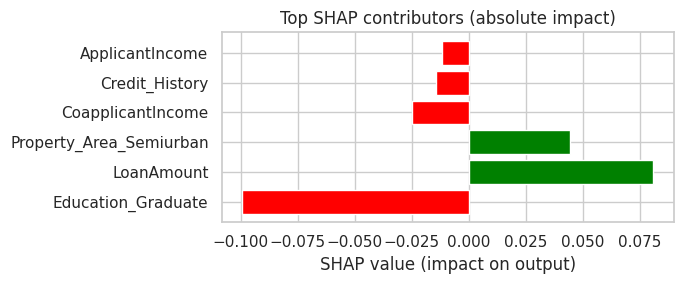

In [ ]:
# interactive one-by-one input -> LightGBM prediction + SHAP explanation (Colab)

# 0) Imports
import os
import sys
import joblib
import glob
import lightgbm as lgb
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# 1) Ensure local artifacts folder exists
LOCAL_ARTIFACTS = "/content/artifacts"
os.makedirs(LOCAL_ARTIFACTS, exist_ok=True)

# 2) Helper: try to copy artifacts from Drive (session-only) if not present locally
def ensure_artifacts(local_dir=LOCAL_ARTIFACTS, drive_project_folder="Infosys project"):
    filenames = {
        "transformer": "transformer.joblib",
        "lightgbm": "lightgbm.txt",
        "logistic": "logistic.pkl",
        "isotonic": "isotonic.joblib"
    }
    missing = [v for v in filenames.values() if not os.path.exists(os.path.join(local_dir, v))]
    if not missing:
        return local_dir  # already present locally

    # Try to mount Drive and copy from expected folder
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=False)
    except Exception:
        # not in Colab or mounting failed - just continue to check
        pass

    drive_candidate = os.path.join("/content/drive/My Drive", drive_project_folder)
    copied = []
    if os.path.exists(drive_candidate):
        for key, fname in filenames.items():
            src = os.path.join(drive_candidate, fname)
            dst = os.path.join(local_dir, fname)
            if os.path.exists(src) and not os.path.exists(dst):
                try:
                    !cp -v "{src}" "{dst}"
                except Exception:
                    # fallback Python copy if shell cp not allowed
                    import shutil
                    shutil.copy(src, dst)
                copied.append(fname)
    else:
        # search Drive recursively for artifacts
        search_patterns = [
            "/content/drive/My Drive/**/transformer*.joblib",
            "/content/drive/My Drive/**/lightgbm*.txt",
            "/content/drive/My Drive/**/logistic*.pkl",
            "/content/drive/My Drive/**/isotonic*.joblib",
        ]
        found_any = False
        for pat in search_patterns:
            matches = glob.glob(pat, recursive=True)
            if matches:
                found_any = True
                for m in matches:
                    dst = os.path.join(local_dir, os.path.basename(m))
                    if not os.path.exists(dst):
                        import shutil
                        shutil.copy(m, dst)
                        copied.append(os.path.basename(m))
        if not found_any:
            # nothing found in Drive
            pass

    missing_after = [v for v in filenames.values() if not os.path.exists(os.path.join(local_dir, v))]
    return local_dir

# Attempt to ensure artifacts available locally (will try Drive copy)
save_dir = ensure_artifacts()

# 3) Check presence of artifacts and show helpful message if missing
required_files = ["transformer.joblib","lightgbm.txt","logistic.pkl","isotonic.joblib"]
missing_now = [f for f in required_files if not os.path.exists(os.path.join(save_dir, f))]
if missing_now:
    raise FileNotFoundError(
        "The following required artifact files are missing in this Colab session:\n"
        + "\n".join(missing_now)
        + "\n\nOptions to fix:\n"
        "1) If your artifacts are in Google Drive, put them into a folder named 'Infosys project' "
        "inside 'My Drive' or change the drive_project_folder in the code above.\n"
        "2) Or upload the files directly using Colab Files > Upload or run:\n"
        "   from google.colab import files\n"
        "   files.upload()\n"
        "Then move them to /content/artifacts or change LOCAL_ARTIFACTS.\n"
    )

# 4) Load artifacts (safe load)
try:
    preprocessor = joblib.load(os.path.join(save_dir, "transformer.joblib"))
except Exception as e:
    raise RuntimeError(f"Failed to load transformer.joblib from {save_dir}: {e}")

try:
    lgb_model = lgb.Booster(model_file=os.path.join(save_dir, "lightgbm.txt"))
except Exception as e:
    raise RuntimeError(f"Failed to load lightgbm.txt from {save_dir}: {e}")

try:
    lr_model = joblib.load(os.path.join(save_dir, "logistic.pkl"))
except Exception as e:
    raise RuntimeError(f"Failed to load logistic.pkl from {save_dir}: {e}")

try:
    iso_model = joblib.load(os.path.join(save_dir, "isotonic.joblib"))
except Exception as e:
    raise RuntimeError(f"Failed to load isotonic.joblib from {save_dir}: {e}")

print("✅ Artifacts loaded from:", save_dir)
print("Transformer shape/attributes (if available):", getattr(preprocessor, "transformers_", "no transformers_ attribute"))

# 5) Function to reconstruct transformed feature names (best-effort)
def get_transformed_feature_names(ct):
    # best-effort attempt to recover names after ColumnTransformer
    names = []
    try:
        if hasattr(ct, "transformers_"):
            for name, trans, cols in ct.transformers_:
                if name == "remainder":
                    continue
                # handle pipeline
                if hasattr(trans, "named_steps"):
                    last = list(trans.named_steps.values())[-1]
                else:
                    last = trans
                if hasattr(last, "get_feature_names_out"):
                    try:
                        out = last.get_feature_names_out(cols)
                        names.extend(list(out))
                    except Exception:
                        if isinstance(cols, (list, tuple, np.ndarray)):
                            names.extend(list(cols))
                        else:
                            names.append(str(cols))
                else:
                    if isinstance(cols, (list, tuple, np.ndarray)):
                        names.extend(list(cols))
                    else:
                        names.append(str(cols))
    except Exception:
        pass
    # fallback: transform a dummy sample to determine column count
    if not names:
        try:
            # try reading dataset if available
            if os.path.exists("/content/dataset.csv"):
                sample = pd.read_csv("/content/dataset.csv", nrows=2)
                for c in ['Loan_Status','approved','Loan_ID']:
                    if c in sample.columns:
                        sample = sample.drop(columns=[c], errors='ignore')
                arr = ct.transform(sample)
            else:
                # create dummy input from preprocessor input features if possible (best-effort)
                # can't reliably infer; fallback to generic names
                arr = np.zeros((1, 50))
            ncols = arr.shape[1]
            names = [f"f{i}" for i in range(ncols)]
        except Exception:
            names = [f"f{i}" for i in range(50)]
    return names

feature_names = get_transformed_feature_names(preprocessor)
print("Recovered transformed feature count:", len(feature_names))

# 6) Interactive prompt -> build input DataFrame
def prompt_customer():
    print("\nEnter customer details. Press Enter to accept the default in [] or type value.")
    def ask(prompt_text, cast=str, default=""):
        raw = input(f"{prompt_text} [{default}]: ").strip()
        if raw == "":
            if default == "":
                return None
            try:
                return cast(default)
            except:
                return default
        try:
            return cast(raw)
        except:
            return raw

    Gender = ask("Gender (Male/Female)", str, "Male")
    Married = ask("Married (Yes/No)", str, "Yes")
    Dependents = ask("Dependents (0/1/2/3+)", str, "0")
    Education = ask("Education (Graduate/Not Graduate)", str, "Graduate")
    Self_Employed = ask("Self_Employed (Yes/No)", str, "No")
    ApplicantIncome = ask("ApplicantIncome (numeric)", float, "5000")
    CoapplicantIncome = ask("CoapplicantIncome (numeric)", float, "0")
    LoanAmount = ask("LoanAmount (numeric)", float, "128")
    Loan_Amount_Term = ask("Loan_Amount_Term (numeric)", float, "360")
    Credit_History = ask("Credit_History (0 or 1)", float, "1")
    Property_Area = ask("Property_Area (Urban/Semiurban/Rural)", str, "Urban")

    row = {
        "Gender": Gender,
        "Married": Married,
        "Dependents": Dependents,
        "Education": Education,
        "Self_Employed": Self_Employed,
        "ApplicantIncome": ApplicantIncome,
        "CoapplicantIncome": CoapplicantIncome,
        "LoanAmount": LoanAmount,
        "Loan_Amount_Term": Loan_Amount_Term,
        "Credit_History": Credit_History,
        "Property_Area": Property_Area
    }
    return pd.DataFrame([row])

# 7) Predict + explain function (uses SHAP -> matplotlib bar)
def predict_and_explain(input_df, top_k=6):
    # transform
    try:
        X_t = preprocessor.transform(input_df)
    except Exception as e:
        raise RuntimeError(f"Preprocessing failed. Check that input columns match training features. Error: {e}")

    # predictions
    p_raw = float(lgb_model.predict(X_t)[0])
    try:
        p_cal = float(iso_model.predict([p_raw])[0])
    except Exception:
        p_cal = p_raw
    try:
        p_lr = float(lr_model.predict_proba(X_t)[:,1][0])
    except Exception:
        p_lr = None

    # label
    label = "Approved" if p_cal >= 0.8 else ("Borderline" if p_cal >= 0.5 else "Rejected")

    # print summary
    print("\n=== Prediction Summary ===")
    print(f"Raw LGB prob: {p_raw:.4f}")
    print(f"Calibrated prob: {p_cal:.4f}")
    print(f"Logistic prob: {p_lr:.4f}" if p_lr is not None else "Logistic prob: N/A")
    print(f"Decision label: {label}")

    # SHAP explain
    explainer = shap.TreeExplainer(lgb_model)
    shap_vals = explainer.shap_values(X_t)
    if isinstance(shap_vals, list) and len(shap_vals) == 2:
        shap_arr = np.array(shap_vals[1])[0]
    else:
        shap_arr = np.array(shap_vals)[0]

    # get feature names matching shap vector
    if feature_names and len(feature_names) == shap_arr.shape[0]:
        names = feature_names
    else:
        names = [f"f{i}" for i in range(shap_arr.shape[0])]

    # top_k contributors
    idx = np.argsort(-np.abs(shap_arr))[:top_k]
    print("\nTop SHAP contributors:")
    for i in idx:
        print(f" - {names[i]}: {shap_arr[i]:+.4f} -> {'increases' if shap_arr[i]>0 else 'decreases'} probability")

    # bar plot
    vals = shap_arr[idx]
    labs = [names[i] for i in idx]
    colors = ['green' if v>0 else 'red' for v in vals]
    plt.figure(figsize=(7, max(2, 0.5*len(vals))))
    plt.barh(range(len(vals))[::-1], vals[::-1], color=colors[::-1])
    plt.yticks(range(len(vals)), labs[::-1])
    plt.xlabel("SHAP value (impact on output)")
    plt.title("Top SHAP contributors (absolute impact)")
    plt.tight_layout()
    plt.show()

    # return dictionary for programmatic use
    return {
        "p_raw": p_raw,
        "p_calibrated": p_cal,
        "p_logistic": p_lr,
        "label": label,
        "top_shap": [{"feature": names[i], "shap": float(shap_arr[i])} for i in idx]
    }

# 8) Run interactive flow
input_df = prompt_customer()
print("\nYou entered:")
display(input_df)
res = predict_and_explain(input_df)
